In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers
print(tf.__version__)

2.1.0


In [0]:
(training_set,validation_set),dataset_info = tfds.load('rock_paper_scissors',split=['train','test'],as_supervised=True,with_info=True)

In [3]:
dataset_info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)

In [4]:
num_classes = dataset_info.features['label'].num_classes
labels = dataset_info.features['label'].names

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print(f'Total number of classes are {num_classes}')
print(f'The labels of dataset are {labels}')
print(f'Training examples: {num_training_examples} and Validation examples: {num_validation_examples}')

Total number of classes are 3
The labels of dataset are ['rock', 'paper', 'scissors']
Training examples: 2520 and Validation examples: 372


**Reformating the image to apply MobileNet V2 (224 X 224)**

In [0]:
image_res = 224

batch_size = 32

def format_image(image,label):
  image = tf.image.resize(image,(image_res, image_res))/255.0
  return image,label

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(batch_size).prefetch(1)

validation_batches = validation_set.map(format_image).batch(batch_size).prefetch(1)

In [0]:
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(url,input_shape = (image_res,image_res,3))

#Freezing the pre-trained model by turning off trainable variable

feature_extractor.trainable = False

In [7]:
#Adding the last layer with pre-trained model

model = tf.keras.Sequential([feature_extractor,layers.Dense(num_classes)])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [8]:
#Fitting the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])
epochs = 6

history = model.fit(train_batches, epochs=epochs, validation_data=validation_batches)

Epoch 1/6
79/79 [==============================] - 13s 160ms/step - loss: 0.2944 - accuracy: 0.9210 - val_loss: 0.3966 - val_accuracy: 0.8306
Epoch 2/6
79/79 [==============================] - 8s 106ms/step - loss: 0.0568 - accuracy: 0.9980 - val_loss: 0.3798 - val_accuracy: 0.8253
Epoch 3/6
79/79 [==============================] - 8s 106ms/step - loss: 0.0303 - accuracy: 0.9996 - val_loss: 0.3749 - val_accuracy: 0.8118
Epoch 4/6
79/79 [==============================] - 8s 108ms/step - loss: 0.0194 - accuracy: 1.0000 - val_loss: 0.3088 - val_accuracy: 0.8710
Epoch 5/6
79/79 [==============================] - 8s 106ms/step - loss: 0.0138 - accuracy: 1.0000 - val_loss: 0.3518 - val_accuracy: 0.8226
Epoch 6/6
79/79 [==============================] - 8s 106ms/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.3665 - val_accuracy: 0.8118


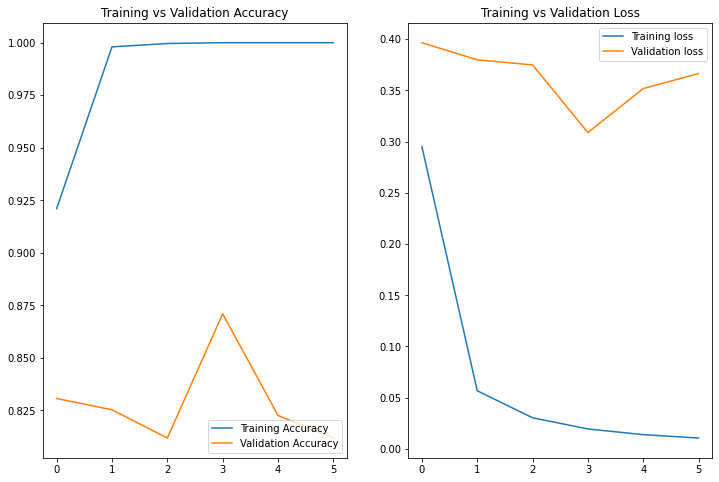

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training loss')
plt.plot(epochs_range,val_loss,label = 'Validation loss')
plt.legend(loc = 'upper right')
plt.title('Training vs Validation Loss')
plt.show()

In [11]:
#creating batch and making predictons
labels = np.array(labels)

labels

array(['rock', 'paper', 'scissors'], dtype='<U8')

In [12]:
image_batch, label_batch = next(iter(train_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch,axis=1)
predicted_class_names = labels[predicted_ids]

print(predicted_class_names)

['rock' 'scissors' 'paper' 'paper' 'paper' 'paper' 'rock' 'paper' 'rock'
 'scissors' 'paper' 'rock' 'rock' 'rock' 'paper' 'rock' 'rock' 'scissors'
 'rock' 'scissors' 'scissors' 'paper' 'paper' 'rock' 'paper' 'paper'
 'rock' 'scissors' 'scissors' 'paper' 'paper' 'paper']


**Compare True labels and Predicted labels**

In [13]:
print('Labels: ',label_batch)
print('Predictions: ',predicted_ids)

Labels:  [0 2 1 1 1 1 0 1 0 2 1 0 0 0 1 0 0 2 0 2 2 1 1 0 1 1 0 2 2 1 1 1]
Predictions:  [0 2 1 1 1 1 0 1 0 2 1 0 0 0 1 0 0 2 0 2 2 1 1 0 1 1 0 2 2 1 1 1]


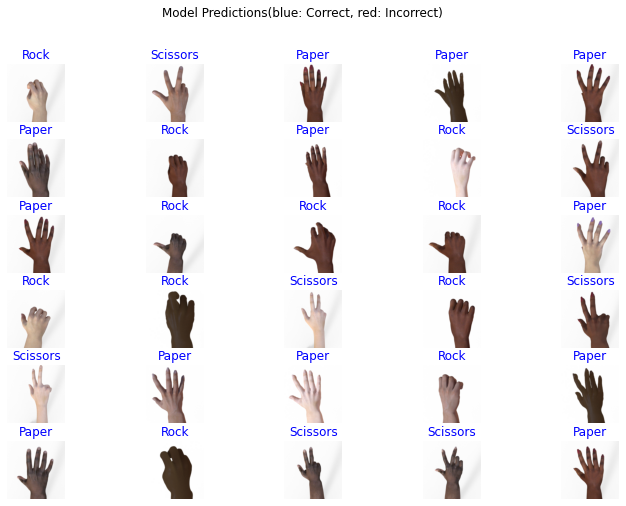

In [16]:
plt.figure(figsize =(12,8))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace=0.3)
  plt.imshow(image_batch[n])
  color = 'blue' if predicted_ids[n] == label_batch[n] else 'red'
  plt.title(predicted_class_names[n].title(), color = color)
  plt.axis('off')
  _ = plt.suptitle('Model Predictions(blue: Correct, red: Incorrect)')

**Lets try with Inception V3 Architecture (299 X 299)**

In [17]:
image_resolution = 299
BATCH_SIZE = 32

(training_set,validation_set),dataset_info = tfds.load('rock_paper_scissors',split=['train','test'],as_supervised=True,with_info=True)

def image_format(image,label):
  image = tf.image.resize(image,(image_resolution,image_resolution))/255.0
  return image,label


train_batches = training_set.shuffle(num_training_examples//4).map(image_format).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(image_format).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(image_resolution, image_resolution, 3),
  trainable=False)

model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model_inception.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


In [18]:
model_inception.compile(
  optimizer='adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model_inception.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
79/79 [==============================] - 17s 211ms/step - loss: 0.3915 - accuracy: 0.9194 - val_loss: 0.6882 - val_accuracy: 0.7473
Epoch 2/6
79/79 [==============================] - 11s 145ms/step - loss: 0.1051 - accuracy: 0.9909 - val_loss: 0.6029 - val_accuracy: 0.8065
Epoch 3/6
79/79 [==============================] - 11s 145ms/step - loss: 0.0589 - accuracy: 0.9952 - val_loss: 0.6548 - val_accuracy: 0.7661
Epoch 4/6
79/79 [==============================] - 11s 145ms/step - loss: 0.0403 - accuracy: 0.9976 - val_loss: 0.6129 - val_accuracy: 0.7957
Epoch 5/6
79/79 [==============================] - 11s 144ms/step - loss: 0.0289 - accuracy: 0.9980 - val_loss: 0.7079 - val_accuracy: 0.7581
Epoch 6/6
79/79 [==============================] - 11s 146ms/step - loss: 0.0227 - accuracy: 0.9984 - val_loss: 0.6872 - val_accuracy: 0.7823


**Train with Resnet Feature Extractor (224 X 224)**

In [19]:
image_resolution = 224
BATCH_SIZE = 32

(training_set,validation_set),dataset_info = tfds.load('rock_paper_scissors',split=['train','test'],as_supervised=True,with_info=True)

def image_format(image,label):
  image = tf.image.resize(image,(image_resolution,image_resolution))/255.0
  return image,label


train_batches = training_set.shuffle(num_training_examples//4).map(image_format).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(image_format).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/imagenet/resnet_v1_152/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(image_resolution, image_resolution, 3),
  trainable=False)

model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model_inception.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 2048)              58295232  
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 6147      
Total params: 58,301,379
Trainable params: 6,147
Non-trainable params: 58,295,232
_________________________________________________________________


In [20]:
model_inception.compile(
  optimizer='adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model_inception.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
79/79 [==============================] - 21s 263ms/step - loss: 0.3109 - accuracy: 0.8921 - val_loss: 0.3606 - val_accuracy: 0.8441
Epoch 2/6
79/79 [==============================] - 11s 146ms/step - loss: 0.0393 - accuracy: 0.9992 - val_loss: 0.3288 - val_accuracy: 0.8522
Epoch 3/6
79/79 [==============================] - 11s 145ms/step - loss: 0.0219 - accuracy: 1.0000 - val_loss: 0.2935 - val_accuracy: 0.8629
Epoch 4/6
79/79 [==============================] - 11s 145ms/step - loss: 0.0145 - accuracy: 1.0000 - val_loss: 0.2958 - val_accuracy: 0.8656
Epoch 5/6
79/79 [==============================] - 12s 147ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.3059 - val_accuracy: 0.8656
Epoch 6/6
79/79 [==============================] - 12s 146ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.3412 - val_accuracy: 0.8575
